In [78]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import seaborn as sns; sns.set()

# Potential function

In [2]:
# As defined in C function
def _logsumexp(xx,m):
    _max = xx[0]
    for j in range(m):
        if xx[j] > _max:
            _max = xx[j]

    _sum = 0;
    for j in range(m):
        _sum += np.exp(xx[j] - _max);

    return _max + np.log(_sum)

def pot_value(x,params):
    pot = 1
    a = params[0]
    b = params[1]
    d = params[2]
    g = params[3]
    k = params[4]
    e = params[5]

    a_inv = 1./a

    grad = np.zeros(M)
    wksp = np.zeros(M)

    utility = 0
    for i in range(N):
        for j in range(M):
            wksp[j] = a*x[j] - b*c[i,j]
        temp = _logsumexp(wksp,M)

        utility += -e*a_inv*o[i]*temp;

        for j in range(M):
            grad[j] += -e*o[i]*np.exp(wksp[j]-temp)

    for j in range(M):
        grad[j] += k*np.exp(x[j]) - d
        grad[j] *= g


    # Compute cost and additional utilities
    cost = k * np.sum(np.exp(x))
    additional = -d * np.sum(x)

    potential = g*e*(utility+cost+additional)

    return potential,grad

# Import data

## Import specified dataset

In [3]:
# Choose dataset
dataset = "synthetic"
# Define possible alphas
alphas = [0.5,1.0,1.5,2.0]
# Select index of alpha
idx = 3
# Select model ('singly' or 'doubly')
model = 'singly'


# Select burn in (in terms of number of iterations)
burnin = 0

In [43]:
# Import relevant data
origin_supply = np.loadtxt(f'../data/input/{dataset}/origin_supply.txt')
initial_destination_sizes = np.loadtxt(f'../data/input/{dataset}/initial_destination_sizes.txt')
cost_matrix = np.loadtxt(f'../data/input/{dataset}/cost_matrix.txt')
destinations = np.loadtxt(f'../data/input/{dataset}/destinations.txt',dtype='str')

# Store dimensions
N,M = cost_matrix.shape

# Define log sizes
xd = np.log(initial_destination_sizes/np.sum(initial_destination_sizes))
# Define normalised cost_matrix
c = cost_matrix/np.sum(cost_matrix)
# Define normalised origin_supply
o = origin_supply/np.sum(origin_supply)

# Run HMC

In [141]:
# Fix random seed
np.random.seed(888)

# Set theta for high-noise model's potential value parameters
alpha = 2.0
beta = 0.3*0.7e6
_delta = 0.3
gamma = 10000
kappa = 1 + _delta
delta = _delta/M

# MCMC tuning parameters
# Number of leapfrog steps
L = 100
# Leapfrog step size
epsilon = 0.1
# Number of iterations
mcmc_n = 10000

In [142]:
# Convert to np array
theta = np.array([alpha,beta,delta,gamma,kappa,1])

# Inverse temperatures that go into potential energy of Hamiltonian dynamics
inverse_temperatures = np.array([1., 1./2., 1./4., 1./8., 1./16.])
temp_n = len(inverse_temperatures)

# Array to store X values sampled at each iteration
samples = np.empty((mcmc_n, M))

# Initialize MCMC
xx = -np.log(M)*np.ones((temp_n, M))

# Initiliase arrays for potential value and its gradient
V = np.empty(temp_n)
gradV = np.empty((temp_n, M))
positions = np.empty((mcmc_n+1, M))
positions[0,:] = xx[0]

# Get potential value and its gradient for the initial choice of theta and x
for j in range(temp_n):
    V[j], gradV[j] = pot_value(xx[j],theta)

# Counts to keep track of accept rates
ac = np.zeros(temp_n)
pc = np.zeros(temp_n)
acs = 0
pcs = 1


# Iterator for number of mcmc runs
n = 0

# MCMC algorithm
for i in tqdm(range(mcmc_n)):
    for j in range(temp_n):
        # Initialise leapfrog integrator for HMC proposal

        ''' HMC parameter/function correspondence to spatial interaction model
        q = x : position or log destination sizes
        U(x) = gamma*V(x|theta)*(1/T) :  potential energy or potential value given parameter theta times inverse temperature

        Note that the potential value function returns gamma*V(x|theta)
        '''

        # X-Proposal (position q is the log size vector X)
        x_p = xx[j]

        # Initialise momentum
        p = np.random.normal(0., 1., M)
        # Set current momentum
        p_p = p
        # Get potential value and its Jacobian
        V_p, gradV_p = V[j], gradV[j]
        # Make a half step for momentum in the beginning
        # inverse_temps[j]*gradV_p = grad V(x|theta)*(1/T)
        p_p -= 0.5*epsilon*inverse_temperatures[j]*gradV_p

        # Hamiltonian total energy function = kinetic energy + potential energy
        # at the beginning of trajectory
        # Kinetic energy K(p) = p^TM^{−1}p / 2 with M being the identity matrix
        H = 0.5*np.dot(p, p) + inverse_temperatures[j]*V[j]

        # Alternate full steps for position and momentum
        for l in range(L):
            # Make a full step for the position
            x_p += epsilon*p_p
            # Update potential value and its gradient
            V_p, gradV_p = pot_value(x_p,theta)
            # Make a full step for the momentum except at the end of trajectory
            if (l != (L-1)):
                p_p -= 0.5*epsilon*inverse_temperatures[j]*gradV_p

        # Make a falf step for momentum at the end.
        p_p -= 0.5*epsilon*inverse_temperatures[j]*gradV_p

        # Negate momentum
        p_p *= (-1)
        
        # Store positions
#         n += 1
#         positions[n,:] = x_p

        # Increment proposal count
        pc[j] += 1

        # Compute Hamiltonian total energy function at the end of trajectory
        H_p = 0.5*np.dot(p_p, p_p) + inverse_temperatures[j]*V_p

        # Accept/reject X by either returning the position at the end of the trajectory or the initial position
        if np.log(np.random.uniform(0, 1)) < H - H_p:
            xx[j] = x_p
            V[j], gradV[j] = V_p, gradV_p
            ac[j] += 1

    # Perform a swap
    pcs += 1
    j0 = np.random.randint(0, temp_n-1)
    j1 = j0+1
    logA = (inverse_temperatures[j1]-inverse_temperatures[j0])*(-V[j1] + V[j0])
    if np.log(np.random.uniform(0, 1)) < logA:
        xx[[j0, j1]] = xx[[j1, j0]]
        V[[j0, j1]] = V[[j1, j0]]
        gradV[[j0, j1]] = gradV[[j1, j0]]
        acs += 1

    # Update stored Markov-chain
    samples[i] = xx[0]

    # Savedown and output details every 100 iterations
    if (i+1) % (int(0.05*mcmc_n)) == 0:
        print("Iteration " + str(i+1))
        print("X AR:")
        print(ac/pc)
        print("Swap AR:" + str(float(acs)/float(pcs)))

  0%|          | 4/10000 [00:00<11:11, 14.89it/s]/Users/Yannis/.pyenv/versions/stdm/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp
/Users/Yannis/.pyenv/versions/stdm/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in exp
  5%|▌         | 502/10000 [00:37<09:30, 16.64it/s]  

Iteration 500
X AR:
[0. 0. 0. 0. 0.]
Swap AR:0.998003992015968


 10%|█         | 1002/10000 [01:10<12:43, 11.78it/s]

Iteration 1000
X AR:
[0. 0. 0. 0. 0.]
Swap AR:0.999000999000999


 15%|█▌        | 1501/10000 [01:54<14:35,  9.70it/s]

Iteration 1500
X AR:
[0. 0. 0. 0. 0.]
Swap AR:0.9993337774816788


 20%|██        | 2003/10000 [02:28<07:36, 17.52it/s]  

Iteration 2000
X AR:
[0. 0. 0. 0. 0.]
Swap AR:0.9995002498750625


 25%|██▌       | 2503/10000 [02:58<07:19, 17.08it/s]

Iteration 2500
X AR:
[0. 0. 0. 0. 0.]
Swap AR:0.9996001599360256


 30%|███       | 3002/10000 [03:33<06:51, 17.01it/s]

Iteration 3000
X AR:
[0. 0. 0. 0. 0.]
Swap AR:0.9996667777407531


 35%|███▌      | 3503/10000 [04:01<05:41, 19.02it/s]

Iteration 3500
X AR:
[0. 0. 0. 0. 0.]
Swap AR:0.9997143673236218


 40%|████      | 4003/10000 [04:27<04:57, 20.18it/s]

Iteration 4000
X AR:
[0. 0. 0. 0. 0.]
Swap AR:0.9997500624843789


 45%|████▌     | 4502/10000 [04:55<05:52, 15.58it/s]

Iteration 4500
X AR:
[0. 0. 0. 0. 0.]
Swap AR:0.9997778271495223


 50%|█████     | 5003/10000 [05:23<05:24, 15.39it/s]

Iteration 5000
X AR:
[0. 0. 0. 0. 0.]
Swap AR:0.9998000399920016


 55%|█████▌    | 5503/10000 [05:54<04:52, 15.37it/s]

Iteration 5500
X AR:
[0. 0. 0. 0. 0.]
Swap AR:0.9998182148700236


 60%|██████    | 6003/10000 [06:23<03:32, 18.82it/s]

Iteration 6000
X AR:
[0. 0. 0. 0. 0.]
Swap AR:0.9998333611064822


 65%|██████▌   | 6502/10000 [06:51<04:43, 12.33it/s]

Iteration 6500
X AR:
[0. 0. 0. 0. 0.]
Swap AR:0.9998461775111521


 70%|███████   | 7003/10000 [07:23<02:57, 16.84it/s]

Iteration 7000
X AR:
[0. 0. 0. 0. 0.]
Swap AR:0.999857163262391


 75%|███████▌  | 7503/10000 [07:52<02:25, 17.14it/s]

Iteration 7500
X AR:
[0. 0. 0. 0. 0.]
Swap AR:0.9998666844420744


 80%|████████  | 8002/10000 [08:20<01:58, 16.93it/s]

Iteration 8000
X AR:
[0. 0. 0. 0. 0.]
Swap AR:0.9998750156230471


 85%|████████▌ | 8502/10000 [08:50<01:28, 16.85it/s]

Iteration 8500
X AR:
[0. 0. 0. 0. 0.]
Swap AR:0.9998823667803788


 90%|█████████ | 9003/10000 [09:16<00:49, 19.95it/s]

Iteration 9000
X AR:
[0. 0. 0. 0. 0.]
Swap AR:0.9998889012331963


 95%|█████████▌| 9502/10000 [09:46<00:26, 18.71it/s]

Iteration 9500
X AR:
[0. 0. 0. 0. 0.]
Swap AR:0.9998947479212714


100%|██████████| 10000/10000 [10:14<00:00, 16.26it/s]

Iteration 10000
X AR:
[0. 0. 0. 0. 0.]
Swap AR:0.9999000099990001


# Visualise posterior samples

## Specified dataset

In [132]:
# Select dimension of samples to visualise 
dim = 0

assert dim >= 0 and dim <= samples.shape[1]

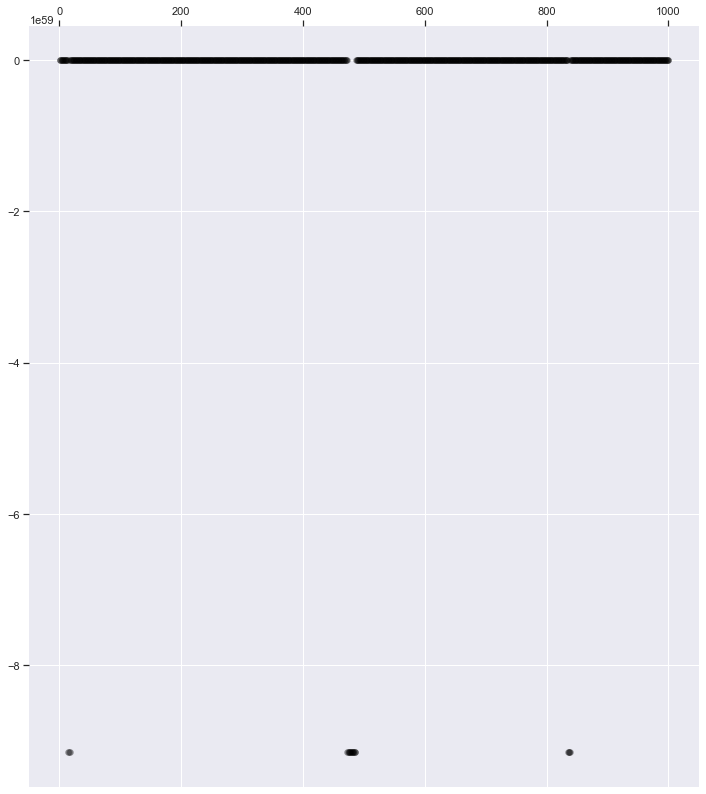

In [133]:
# Plot samples
plt.figure(figsize=(12, 14)) 

ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_top()    
ax.get_yaxis().tick_left()    
  
plt.scatter(range(1,samples.shape[0]+1), samples[:,dim], lw=0.5, color="black", alpha=0.3)    

plt.show()

In [136]:
# Compute discrepancy between actual and estimated latents
estimated_sizes = np.sum(samples,axis=0)
estimated_sizes

array([-1.92328770e+61, -3.66405487e+77])

In [137]:
xd

array([-1.09861229, -0.40546511])

## Posterior sample scatter plot

(-1.6284688302730554e+76, -1.2199031482286857)

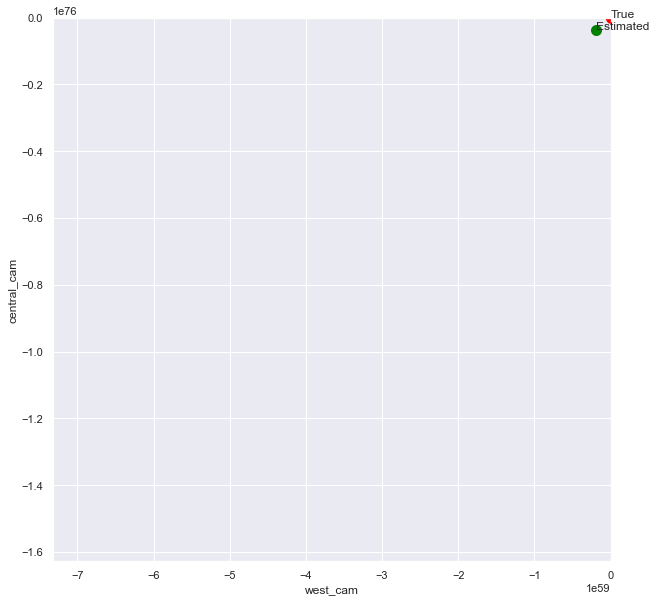

In [138]:
plt.figure(figsize=(10,10))
plt.scatter(samples[:,0],samples[:,1],alpha=0.2)
plt.scatter(xd[0],xd[1],color='red',s=100)
plt.scatter(np.mean(samples[:,0]),np.mean(samples[:,1]),color='green',s=100)
plt.xlabel(destinations[0])
plt.ylabel(destinations[1])
plt.annotate(s='True',xy=(xd[0],xd[1]))
plt.annotate(s='Estimated',xy=(np.mean(samples[:,0]),np.mean(samples[:,1])))
plt.xlim([np.min(samples[:,0])*(4/5), np.max(samples[:,0])*(5/4)])
plt.ylim([np.min(samples[:,1])*(4/5), np.max(samples[:,1])*(5/4)])

### Sample from a Normal centered around destination demands

In [85]:
if model == 'doubly':
    # Import destination demand
    dest_demand = np.loadtxt(f"../data/input/{dataset}/destination_demand.txt")

    # Sample from normal
    baseline_latent_samples = np.random.multivariate_normal(dest_demand[:,0], 0.2*np.identity(dest_demand[:,0].shape[0]), 10000)
    baseline_latents = np.sum(baseline_latent_samples,axis=0)

    # Normalise and take logs
    baseline_latents = np.log(baseline_latents/np.sum(baseline_latents))
    
    print('Naive baseline destination sizes sampled from a Normal centered around destination demand - log normalised')
    baseline_latents

In [86]:
print('HMC sampled latent destination sizes - log normalised')
estimated_sizes

HMC sampled latent destination sizes - log normalised


array([-3992.84575066, -4498.84236433])

In [95]:
print('Actual destination sizes log normalised')
xd

Actual destination sizes log normalised


array([-1.09861229, -0.40546511])

In [91]:
print("Ratio of HMC sampled latent sizes to actual sizes")
estimated_sizes/xd

Ratio of HMC sampled latent sizes to actual sizes


array([ 3634.44482812, 11095.51049983])

In [93]:
if model == 'doubly':
    print("Ratio of baseline destination sizes to actual destination sizes")
    print(baseline_latents/xd)

## Retail data

In [ ]:
# Select dimension of samples to visualise 
dim = 4

assert dim >= 0 and dim <= retail_latents.shape[1]

In [ ]:
# Plot samples
plt.figure(figsize=(12, 14)) 

ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_top()    
ax.get_yaxis().tick_left()    
  
plt.scatter(range(1,retail_latents.shape[0]+1), retail_latents[:,dim], lw=0.5, color="black", alpha=0.3)    

plt.show()

# Measure discrepancy between estimated and actual latent sizes

In [ ]:
# Compute discrepancy between actual and estimated latents
retail_estimated_sizes = np.sum(retail_latents,axis=0)

In [ ]:
retail_estimated_sizes

In [ ]:
retail_xd0

In [ ]:
retail_estimated_sizes/retail_xd0